#CLASSIFIER MODELS FOR PARKINSON'S DISEASE SPEECH FEATURES


---


**Data Overview and Exploratory Analysis**


---



**Import Libraries and Load the Dataset**

In [2]:
# load the relevant libraries
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


**Explore the Dataset**

Prior to initiating data preprocessing, exploratory data analysis was performed to understand the data's structure and format, including the types of variables, their distributions, and overall layout of the data, as this exploration would inform the modeling approach.

In [4]:
# load and explore the first 10 rows of the dataset
df = pd.read_csv('/content/pd_speech_features.csv')
print(df.head(10))

   gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0       1  0.85247  0.71826  0.57227        240               239   
1       1  0.76686  0.69481  0.53966        234               233   
2       1  0.85083  0.67604  0.58982        232               231   
3       0  0.41121  0.79672  0.59257        178               177   
4       0  0.32790  0.79782  0.53028        236               235   
5       0  0.50780  0.78744  0.65451        226               221   
6       1  0.76095  0.62145  0.54543        322               321   
7       1  0.83671  0.62079  0.51179        318               317   
8       1  0.80826  0.61766  0.50447        318               317   
9       0  0.85302  0.62247  0.54855        493               492   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  locAbsJitter  ...  \
0          0.008064            0.000087       0.00218      0.000018  ...   
1          0.008258            0.000073       0.00195      0.000016  ...   
2          0

The dataset consists of 754 features and 756 attributes.

In [5]:
# shape of the data
print(df.shape)

(756, 754)


In [6]:
# data information
print('Summary of Data Types:\n', df.dtypes.value_counts(), sep="")

df.info()

Summary of Data Types:
float64    749
int64        5
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 754 entries, gender to class
dtypes: float64(749), int64(5)
memory usage: 4.3 MB


In [7]:
# describe the data
print(df.describe())

           gender         PPE         DFA        RPDE   numPulses  \
count  756.000000  756.000000  756.000000  756.000000  756.000000   
mean     0.515873    0.746284    0.700414    0.489058  323.972222   
std      0.500079    0.169294    0.069718    0.137442   99.219059   
min      0.000000    0.041551    0.543500    0.154300    2.000000   
25%      0.000000    0.762833    0.647053    0.386537  251.000000   
50%      1.000000    0.809655    0.700525    0.484355  317.000000   
75%      1.000000    0.834315    0.754985    0.586515  384.250000   
max      1.000000    0.907660    0.852640    0.871230  907.000000   

       numPeriodsPulses  meanPeriodPulses  stdDevPeriodPulses  locPctJitter  \
count        756.000000        756.000000          756.000000    756.000000   
mean         322.678571          0.006360            0.000383      0.002324   
std           99.402499          0.001826            0.000728      0.002628   
min            1.000000          0.002107            0.000011 

Categorical data type (specifically the target variable 'class') are encoded as integer and are suitable for modelling, requiring no further transformation using hot-encoding.

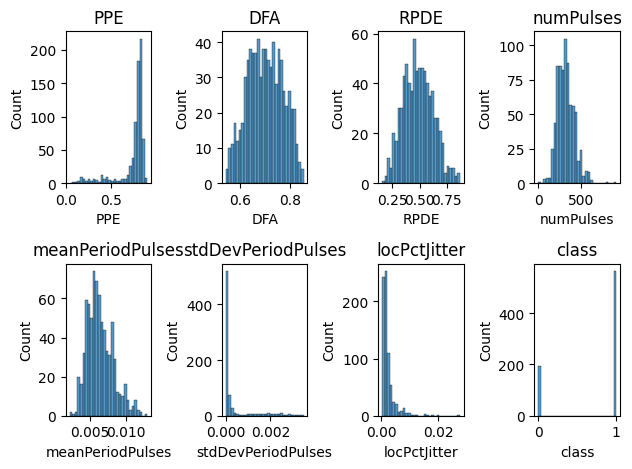

In [8]:
# visualise a subset of columns
columns_to_plot = ['PPE', 'DFA', 'RPDE', 'numPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter', 'class']

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[column], kde=False, bins=30)
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

**Target Variable**

In [9]:
# explore the distribution of the target variable ('class')
print(df['class'].value_counts())

class
1    564
0    192
Name: count, dtype: int64


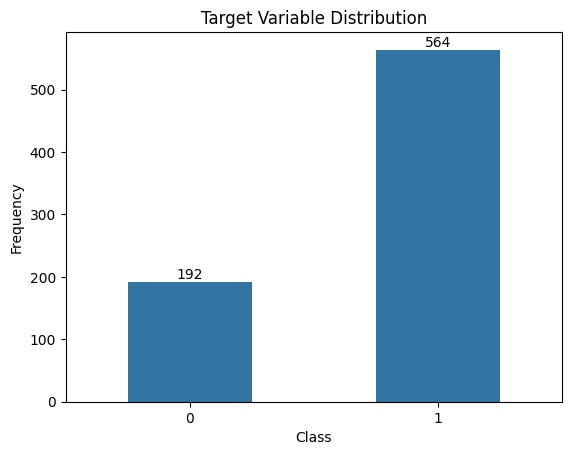

In [10]:
# visualise distribution of the target variable

ax = sns.countplot(x=df['class'], width=0.5)

# add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Target Variable Distribution")
plt.xlabel('Class')
plt.ylabel('Frequency')

# show plot
plt.show()


The output displays the count of the parkinson's disease cases (1) accounting for 564 of the total 756 attributes, compared to Class 0 (192), indicating an unbalanced dataset.

An imbalance like this can lead the model to be biased towards the majority class (Class 1), potentially resulting in poor classification performance for the minority class (Class 0).

Algorithms which are more robust to class imbalance (Random Forest, Support Vector Machine) as well as evaluation metrics that are more apporiate for imbalanced datasets (AUC, Precision, Sensitivity, F1 Score) will be used in this analysis.

**Analyse Missing Data**

The output indicates that there is no missing data within this dataset.

In [11]:
# check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

print(df.isnull().sum())

Missing values in each column:
 Series([], dtype: int64)
gender                       0
PPE                          0
DFA                          0
RPDE                         0
numPulses                    0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 754, dtype: int64


**Assess Multicollinerity**

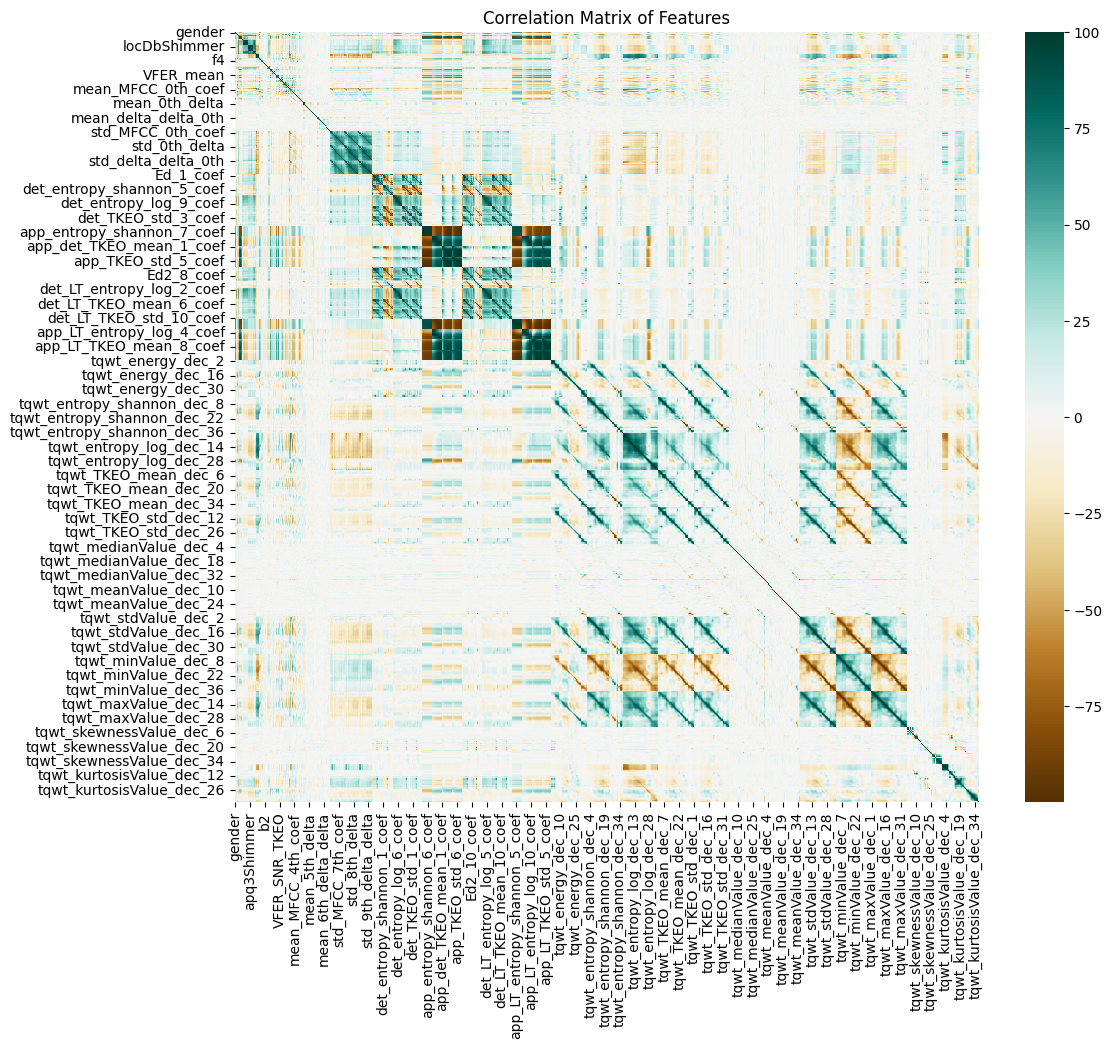

In [12]:
# correlation matrix
correlation_matrix = df.corr()*100

# visualise the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap= 'BrBG')
plt.title('Correlation Matrix of Features')
plt.show()

There appears to be high correlations between features and this may suggest redundancy.This could potentially affect model performances.

Various "tqwt" features such as tqwt_entropy_log_dec_16, tqwt_entropy_shannon_dec_16, and tqwt_TKEO_mean_dec_16 show a high degree of positive correlation with each other. Likewise "det" features like det_LT_entropy_log_10_coef and det_LT_TKEO_mean_10_coef.

Feature selection or dimensionality reduction would be an appopriate method to handle the multicollinearity within this dataset.

Random Forest models tend to handle multicollinerity well, and will be used in this analysis.



#**Data Preprocessing**

**Data Splitting into Training and Test Sets**

Data splitting is done first, to ensure that the scaling and dimensionality reduction are fit only on training data,thereby preserving the integrity of the test set as unseen data.

In [13]:
# separate the dataset into features and target variable
X = df.drop(['class'], axis=1)
y = df['class']

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [14]:
y_train.value_counts()

class
1    395
0    134
Name: count, dtype: int64

In [15]:
y_test.value_counts()

class
1    169
0     58
Name: count, dtype: int64

Allocating 70% of the data (529 samples) for training and 30% (227 samples) for testing.

This provides a substantial test dataset would help to ensure the models are adequately tested against a varied set of unseen data. Making the performance metrics more reliable.

---


# **Modeling**


**Logistic Regression Classifier**



---





In [19]:
# stratified K-Folds cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a pipeline for Logistic Regression Classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # bring features into the same scale
    ('pca', PCA()), #	before conducting PCA for dimensionality reduction, it is important to scale features to prevent bias from measurement units.
    ('logistic', LogisticRegression(solver='liblinear', penalty='l1', random_state=42))
])

# define the parameter grid
param_grid = {
    'pca__n_components': [0.95, 0.90, 0.85],
    'logistic__C': [0.01, 0.1, 1, 10, 100]
}

# scoring dictionary
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1_score': 'f1',
           'auc': 'roc_auc'}

# set and fit GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, refit='auc', return_train_score=True)
grid_search.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'logistic__C': [0.01, 0.1, 1, 10, 100],
                         'pca__n_components': [0.95, 0.9, 0.85]},
             refit='auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'auc': 'roc_auc',
                      'f1_score': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

**Logistic Regression Classifier: Training and Validation Metrics**

In [20]:
cv_results = grid_search.cv_results_

# print training and validation scores
for i in range(len(cv_results['params'])):
    print("\nConfiguration:", cv_results['params'][i])
    print("Mean Training Accuracy: {:.3f}".format(cv_results['mean_train_accuracy'][i]))
    print("Mean Validation Accuracy: {:.3f}".format(cv_results['mean_test_accuracy'][i]))
    print("Mean Training Precision: {:.3f}".format(cv_results['mean_train_precision'][i]))
    print("Mean Validation Precision: {:.3f}".format(cv_results['mean_test_precision'][i]))
    print("Mean Training Recall: {:.3f}".format(cv_results['mean_train_recall'][i]))
    print("Mean Validation Recall: {:.3f}".format(cv_results['mean_test_recall'][i]))
    print("Mean Training F1 Score: {:.3f}".format(cv_results['mean_train_f1_score'][i]))
    print("Mean Validation F1 Score: {:.3f}".format(cv_results['mean_test_f1_score'][i]))
    print("Mean Training AUC: {:.3f}".format(cv_results['mean_train_auc'][i]))
    print("Mean Validation AUC: {:.3f}".format(cv_results['mean_test_auc'][i]))



Configuration: {'logistic__C': 0.01, 'pca__n_components': 0.95}
Mean Training Accuracy: 0.730
Mean Validation Accuracy: 0.726
Mean Training Precision: 0.889
Mean Validation Precision: 0.892
Mean Training Recall: 0.730
Mean Validation Recall: 0.722
Mean Training F1 Score: 0.802
Mean Validation F1 Score: 0.797
Mean Training AUC: 0.832
Mean Validation AUC: 0.819

Configuration: {'logistic__C': 0.01, 'pca__n_components': 0.9}
Mean Training Accuracy: 0.730
Mean Validation Accuracy: 0.726
Mean Training Precision: 0.889
Mean Validation Precision: 0.892
Mean Training Recall: 0.730
Mean Validation Recall: 0.722
Mean Training F1 Score: 0.802
Mean Validation F1 Score: 0.797
Mean Training AUC: 0.832
Mean Validation AUC: 0.819

Configuration: {'logistic__C': 0.01, 'pca__n_components': 0.85}
Mean Training Accuracy: 0.730
Mean Validation Accuracy: 0.726
Mean Training Precision: 0.889
Mean Validation Precision: 0.892
Mean Training Recall: 0.730
Mean Validation Recall: 0.722
Mean Training F1 Score: 0.

**Logistic Regression Classifier: Best Parameters and Test Evaluation Metrics**

In [21]:
# results for best parameters
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation AUC: {:.3f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Set Evaluation Metrics:")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

Best parameters:  {'logistic__C': 0.1, 'pca__n_components': 0.85}
Best cross-validation AUC: 0.875
Test Set Evaluation Metrics:
Accuracy: 0.824
Precision: 0.849
Recall: 0.929
F1 Score: 0.887
AUC: 0.865




---



Support Vector Machine (SVM)
---


**SVM Classifier: with 'rbf' kernel**

---

In [22]:
# stratified K-Folds cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a pipeline for the Support Vector Machine Classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # bring features into the same scale
    ('pca', PCA()),
    ('svm', SVC(probability=True, random_state=42))
])

# define the parameter grid and specify type as kernel 'rbf'
param_grid = {
   'pca__n_components': [0.95, 0.90, 0.85],
   'svm__C': [0.1, 1, 10],
   'svm__gamma': [0.001, 0.01, 0.1, 1, 10],
   'svm__kernel': ['rbf']
}

# score dictionary
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1',
    'auc': 'roc_auc'
}

# set and fit GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, refit='auc', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'pca__n_components': [0.95, 0.9, 0.85],
                         'svm__C': [0.1, 1, 10],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10],
                         'svm__kernel': ['rbf']},
             refit='auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'auc': 'roc_auc',
                      'f1_score': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

**SVM Classifier ('rbf' Kernel): Training and Validation Metrics**

In [23]:
cv_results = grid_search.cv_results_

# print training and validation scores
for i in range(len(cv_results['params'])):
    print("\nConfiguration:", cv_results['params'][i])
    print("Mean Training Accuracy: {:.3f}".format(cv_results['mean_train_accuracy'][i]))
    print("Mean Validation Accuracy: {:.3f}".format(cv_results['mean_test_accuracy'][i]))
    print("Mean Training Precision: {:.3f}".format(cv_results['mean_train_precision'][i]))
    print("Mean Validation Precision: {:.3f}".format(cv_results['mean_test_precision'][i]))
    print("Mean Training Recall: {:.3f}".format(cv_results['mean_train_recall'][i]))
    print("Mean Validation Recall: {:.3f}".format(cv_results['mean_test_recall'][i]))
    print("Mean Training F1 Score: {:.3f}".format(cv_results['mean_train_f1_score'][i]))
    print("Mean Validation F1 Score: {:.3f}".format(cv_results['mean_test_f1_score'][i]))
    print("Mean Training AUC: {:.3f}".format(cv_results['mean_train_auc'][i]))
    print("Mean Validation AUC: {:.3f}".format(cv_results['mean_test_auc'][i]))



Configuration: {'pca__n_components': 0.95, 'svm__C': 0.1, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Mean Training Accuracy: 0.747
Mean Validation Accuracy: 0.747
Mean Training Precision: 0.747
Mean Validation Precision: 0.747
Mean Training Recall: 1.000
Mean Validation Recall: 1.000
Mean Training F1 Score: 0.855
Mean Validation F1 Score: 0.855
Mean Training AUC: 0.907
Mean Validation AUC: 0.834

Configuration: {'pca__n_components': 0.95, 'svm__C': 0.1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Mean Training Accuracy: 0.747
Mean Validation Accuracy: 0.747
Mean Training Precision: 0.747
Mean Validation Precision: 0.747
Mean Training Recall: 1.000
Mean Validation Recall: 1.000
Mean Training F1 Score: 0.855
Mean Validation F1 Score: 0.855
Mean Training AUC: 1.000
Mean Validation AUC: 0.876

Configuration: {'pca__n_components': 0.95, 'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Mean Training Accuracy: 0.747
Mean Validation Accuracy: 0.747
Mean Training Precision: 0.747
Mean Val

**SVM Classifier ('rbf' Kernel): Best Parameters and Test Evaluation Metrics**

In [24]:
# print best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# print test set evaluation metrics
print("Best parameters:", best_params)
print("Best CV AUC: {:.3f}".format(best_score))
print("Test Set Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Test Set Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Test Set Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("Test Set F1 Score: {:.3f}".format(f1_score(y_test, y_pred)))
print("Test Set AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))


Best parameters: {'pca__n_components': 0.85, 'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best CV AUC: 0.917
Test Set Accuracy: 0.837
Test Set Precision: 0.827
Test Set Recall: 0.988
Test Set F1 Score: 0.900
Test Set AUC: 0.950




---


**SVM Classifier: with 'linear' kernel**



---



In [25]:
# stratified K-Folds cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a pipeline for the Support Vector Machine Classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # bring features into the same scale
    ('pca', PCA()),
    ('svm', SVC(probability=True, random_state=42))
])

# define the parameter grid and specify kernel type as 'linear'
param_grid = {
    'pca__n_components': [0.95, 0.90, 0.85],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear']
}

# score dictionary
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1',
    'auc': 'roc_auc'
}

# set and fit GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, refit='auc', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'pca__n_components': [0.95, 0.9, 0.85],
                         'svm__C': [0.1, 1, 10], 'svm__kernel': ['linear']},
             refit='auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'auc': 'roc_auc',
                      'f1_score': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

**SVM Classifier ('linear' Kernel): Training and Validation Metrics**

In [26]:
cv_results = grid_search.cv_results_

# print training and validation scores
for i in range(len(cv_results['params'])):
    print("\nConfiguration:", cv_results['params'][i])
    print("Mean Training Accuracy: {:.3f}".format(cv_results['mean_train_accuracy'][i]))
    print("Mean Validation Accuracy: {:.3f}".format(cv_results['mean_test_accuracy'][i]))
    print("Mean Training Precision: {:.3f}".format(cv_results['mean_train_precision'][i]))
    print("Mean Validation Precision: {:.3f}".format(cv_results['mean_test_precision'][i]))
    print("Mean Training Recall: {:.3f}".format(cv_results['mean_train_recall'][i]))
    print("Mean Validation Recall: {:.3f}".format(cv_results['mean_test_recall'][i]))
    print("Mean Training F1 Score: {:.3f}".format(cv_results['mean_train_f1_score'][i]))
    print("Mean Validation F1 Score: {:.3f}".format(cv_results['mean_test_f1_score'][i]))
    print("Mean Training AUC: {:.3f}".format(cv_results['mean_train_auc'][i]))
    print("Mean Validation AUC: {:.3f}".format(cv_results['mean_test_auc'][i]))



Configuration: {'pca__n_components': 0.95, 'svm__C': 0.1, 'svm__kernel': 'linear'}
Mean Training Accuracy: 0.976
Mean Validation Accuracy: 0.826
Mean Training Precision: 0.975
Mean Validation Precision: 0.876
Mean Training Recall: 0.993
Mean Validation Recall: 0.896
Mean Training F1 Score: 0.984
Mean Validation F1 Score: 0.885
Mean Training AUC: 0.983
Mean Validation AUC: 0.851

Configuration: {'pca__n_components': 0.95, 'svm__C': 1, 'svm__kernel': 'linear'}
Mean Training Accuracy: 0.999
Mean Validation Accuracy: 0.811
Mean Training Precision: 0.998
Mean Validation Precision: 0.866
Mean Training Recall: 1.000
Mean Validation Recall: 0.886
Mean Training F1 Score: 0.999
Mean Validation F1 Score: 0.875
Mean Training AUC: 1.000
Mean Validation AUC: 0.838

Configuration: {'pca__n_components': 0.95, 'svm__C': 10, 'svm__kernel': 'linear'}
Mean Training Accuracy: 1.000
Mean Validation Accuracy: 0.811
Mean Training Precision: 1.000
Mean Validation Precision: 0.864
Mean Training Recall: 1.000
M

**SVM Classifier ('linear' Kernel): Best Parameters and Test Evaluation Metrics**

In [27]:
# print best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# print test set evaluation metrics
print("Best parameters:", best_params)
print("Best CV AUC: {:.3f}".format(best_score))
print("Test Set Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Test Set Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Test Set Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("Test Set F1 Score: {:.3f}".format(f1_score(y_test, y_pred)))
print("Test Set AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))


Best parameters: {'pca__n_components': 0.9, 'svm__C': 0.1, 'svm__kernel': 'linear'}
Best CV AUC: 0.870
Test Set Accuracy: 0.797
Test Set Precision: 0.860
Test Set Recall: 0.870
Test Set F1 Score: 0.865
Test Set AUC: 0.815


---
Random Forest (RF)
---


**RF Classifier with Feature Scaling and PCA**


---



In [28]:
# stratified K-Folds cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a pipeline for the Random Forest Classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),  # typically feature scaling is not necessary for Random Forests, but it is included here for consistency
    ('pca', PCA()),               # in the step PCA will be used, and in subsequent RF model PCA will be ommitted to compare performance
    ('random_forest', RandomForestClassifier(random_state=42))
])

# define the parameter grid
param_grid = {
    'pca__n_components': [0.95, 0.90, 0.85],
    'random_forest__n_estimators': [100, 200, 300],  # Number of trees
    'random_forest__max_features': ['sqrt', 'log2']  # Number of features to consider at every split
}

# scoring dictionary
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1',
    'auc': 'roc_auc'
}

# set and fit GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, refit='auc', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'pca__n_components': [0.95, 0.9, 0.85],
                         'random_forest__max_features': ['sqrt', 'log2'],
                         'random_forest__n_estimators': [100, 200, 300]},
             refit='auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'auc': 'roc_auc',
                      'f1_score': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

**Random Forest with fearture scaling and PCA: Training and Validation Metrics**

In [29]:
cv_results = grid_search.cv_results_

# print training and validation scores
for i in range(len(cv_results['params'])):
    print("\nConfiguration:", cv_results['params'][i])
    print("Mean Training Accuracy: {:.3f}".format(cv_results['mean_train_accuracy'][i]))
    print("Mean Validation Accuracy: {:.3f}".format(cv_results['mean_test_accuracy'][i]))
    print("Mean Training Precision: {:.3f}".format(cv_results['mean_train_precision'][i]))
    print("Mean Validation Precision: {:.3f}".format(cv_results['mean_test_precision'][i]))
    print("Mean Training Recall: {:.3f}".format(cv_results['mean_train_recall'][i]))
    print("Mean Validation Recall: {:.3f}".format(cv_results['mean_test_recall'][i]))
    print("Mean Training F1 Score: {:.3f}".format(cv_results['mean_train_f1_score'][i]))
    print("Mean Validation F1 Score: {:.3f}".format(cv_results['mean_test_f1_score'][i]))
    print("Mean Training AUC: {:.3f}".format(cv_results['mean_train_auc'][i]))
    print("Mean Validation AUC: {:.3f}".format(cv_results['mean_test_auc'][i]))



Configuration: {'pca__n_components': 0.95, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 100}
Mean Training Accuracy: 1.000
Mean Validation Accuracy: 0.785
Mean Training Precision: 1.000
Mean Validation Precision: 0.788
Mean Training Recall: 1.000
Mean Validation Recall: 0.975
Mean Training F1 Score: 1.000
Mean Validation F1 Score: 0.871
Mean Training AUC: 1.000
Mean Validation AUC: 0.787

Configuration: {'pca__n_components': 0.95, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 200}
Mean Training Accuracy: 1.000
Mean Validation Accuracy: 0.785
Mean Training Precision: 1.000
Mean Validation Precision: 0.789
Mean Training Recall: 1.000
Mean Validation Recall: 0.972
Mean Training F1 Score: 1.000
Mean Validation F1 Score: 0.871
Mean Training AUC: 1.000
Mean Validation AUC: 0.789

Configuration: {'pca__n_components': 0.95, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 300}
Mean Training Accuracy: 1.000
Mean Validation A

**Random Forest with feature scaling and PCA: Best Parameters and Test Evaluation Metrics**

In [30]:
# print the best parameters and AUC score
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation AUC: {:.3f}".format(grid_search.best_score_))

# evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# print test set evaluation metrics
print("Test Set Evaluation Metrics:")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))


Best parameters:  {'pca__n_components': 0.85, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 200}
Best cross-validation AUC: 0.842
Test Set Evaluation Metrics:
Accuracy: 0.828
Precision: 0.816
Recall: 0.994
F1 Score: 0.896
AUC: 0.890


---

**RF Classifier without Feature Scaling and PCA**


---



In [31]:
# stratified K-Folds cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([
     ('random_forest', RandomForestClassifier(random_state=42))
])

# define the parameter grid
param_grid = {
    'random_forest__n_estimators': [100, 200, 300],
    'random_forest__max_features': ['sqrt', 'log2']
}

# score dictionary
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1',
    'auc': 'roc_auc'
}

# set and fit GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, refit='auc', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_features': ['sqrt', 'log2'],
                         'random_forest__n_estimators': [100, 200, 300]},
             refit='auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'auc': 'roc_auc',
                      'f1_score': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

**Random Forest without fearture scaling and PCA: Training and Validation Metrics**

In [32]:
cv_results = grid_search.cv_results_

# print training and validation scores
for i in range(len(cv_results['params'])):
    print("\nConfiguration:", cv_results['params'][i])
    print("Mean Training Accuracy: {:.3f}".format(cv_results['mean_train_accuracy'][i]))
    print("Mean Validation Accuracy: {:.3f}".format(cv_results['mean_test_accuracy'][i]))
    print("Mean Training Precision: {:.3f}".format(cv_results['mean_train_precision'][i]))
    print("Mean Validation Precision: {:.3f}".format(cv_results['mean_test_precision'][i]))
    print("Mean Training Recall: {:.3f}".format(cv_results['mean_train_recall'][i]))
    print("Mean Validation Recall: {:.3f}".format(cv_results['mean_test_recall'][i]))
    print("Mean Training F1 Score: {:.3f}".format(cv_results['mean_train_f1_score'][i]))
    print("Mean Validation F1 Score: {:.3f}".format(cv_results['mean_test_f1_score'][i]))
    print("Mean Training AUC: {:.3f}".format(cv_results['mean_train_auc'][i]))
    print("Mean Validation AUC: {:.3f}".format(cv_results['mean_test_auc'][i]))



Configuration: {'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 100}
Mean Training Accuracy: 1.000
Mean Validation Accuracy: 0.868
Mean Training Precision: 1.000
Mean Validation Precision: 0.866
Mean Training Recall: 1.000
Mean Validation Recall: 0.975
Mean Training F1 Score: 1.000
Mean Validation F1 Score: 0.917
Mean Training AUC: 1.000
Mean Validation AUC: 0.910

Configuration: {'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 200}
Mean Training Accuracy: 1.000
Mean Validation Accuracy: 0.877
Mean Training Precision: 1.000
Mean Validation Precision: 0.874
Mean Training Recall: 1.000
Mean Validation Recall: 0.977
Mean Training F1 Score: 1.000
Mean Validation F1 Score: 0.922
Mean Training AUC: 1.000
Mean Validation AUC: 0.914

Configuration: {'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 300}
Mean Training Accuracy: 1.000
Mean Validation Accuracy: 0.871
Mean Training Precision: 1.000
Mean Validation Precision: 0.869
Me

**Random Forest without feature scaling and PCA: Best Parameters and Test Evaluation Metrics**

In [33]:
# print the best parameters and AUC score
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation AUC: {:.3f}".format(grid_search.best_score_))

# evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# print test set evaluation metrics
print("Test Set Evaluation Metrics:")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))


Best parameters:  {'random_forest__max_features': 'log2', 'random_forest__n_estimators': 200}
Best cross-validation AUC: 0.917
Test Set Evaluation Metrics:
Accuracy: 0.863
Precision: 0.863
Recall: 0.970
F1 Score: 0.914
AUC: 0.926


**Bringing features into the same scale**

In [ ]:
from sklearn.preprocessing import StandardScaler

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fit and transform training data


**PCA for Visualisation**

In [ ]:
# apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # reduce to 2 dimensions for visualisation
X_train_pca = pca.fit_transform(X_train_scaled)

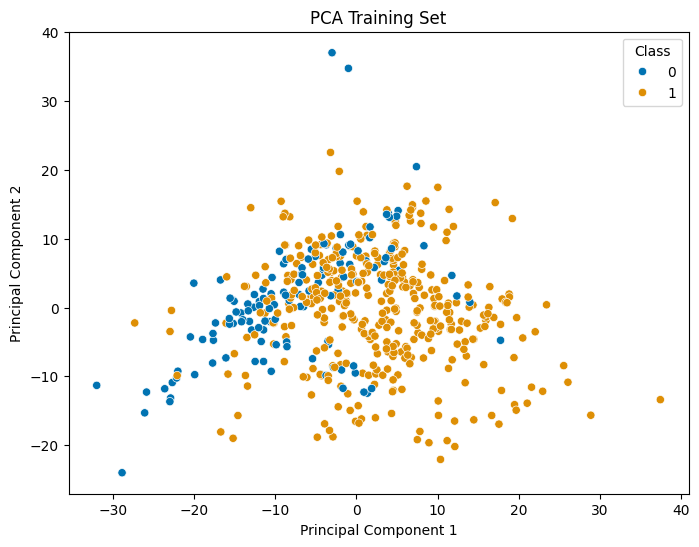

In [ ]:
# visualise the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette= 'colorblind')
plt.title('PCA Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', loc='best')
plt.show()

There appears to be no clear linear boundary that can effectively separate the two classes in this two-dimensional PCA space (non-linear relationships may exist).

The class separation also suggests that the variance captured by the first two Although significant, the principal components may not be sufficient to distinctly classify PD (1) from non-PD (0) cases based on speech features alone.

**Plot 3D**

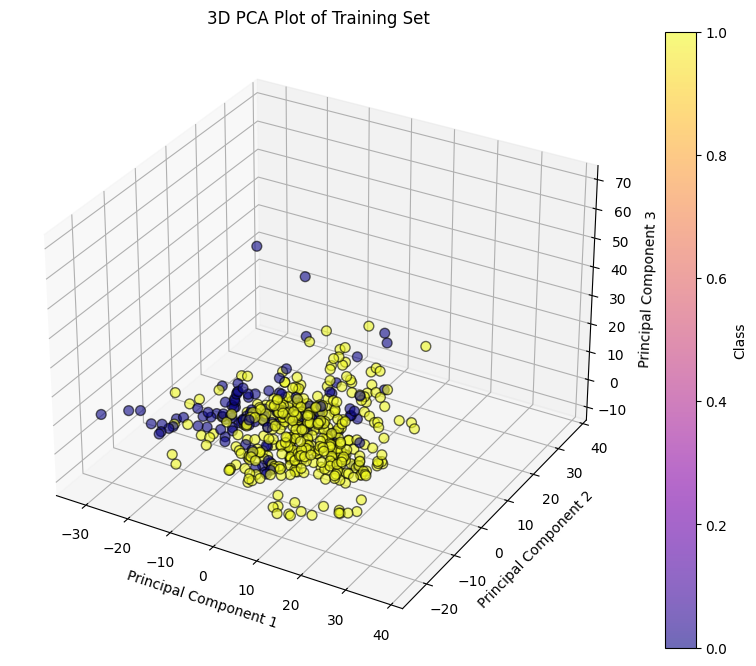

In [ ]:
# apply PCA

pca = PCA(n_components=3) # `n_components` set to 3 for visualisation
X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

# make a 3d scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
#plt.clf()
ax = plt.subplot(111, projection='3d')
sc = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
                c=y_train, cmap='plasma', edgecolor='k', s=50, alpha=0.6)

# labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA Plot of Training Set')
#ax.view_init(elev=40, azim=140)

# legend for classes
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Class')
plt.show()

This distribution indicates some degree of overlap between the classes in the PCA-transformed space, and this suggests that linear separation of the classes could be challenging.

Logistic regrssion classifer is used in this analysis as a form of baseline for the classification and its performance can provide a benchmark to assess the other models.

In [ ]:
pca = PCA().fit(X_train_scaled)

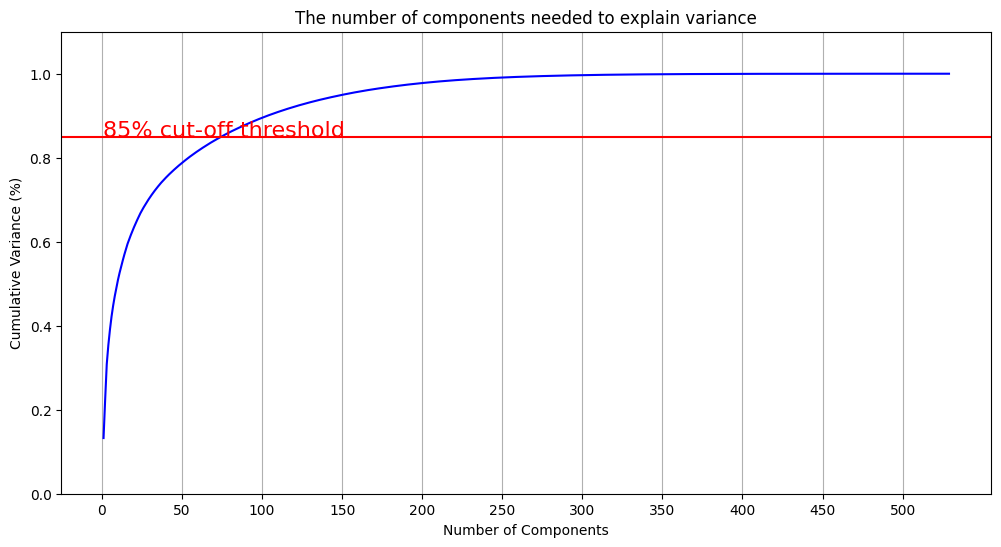

In [ ]:
plt.rcParams["figure.figsize"] = (12, 6)
fig, ax = plt.subplots()
xi = np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, linestyle='-', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(pca.explained_variance_ratio_) + 1, step=50))
plt.ylabel('Cumulative Variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.85, color='r', linestyle='-')
plt.text(0.5, 0.85, '85% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()


In [1]:
!pip install pandoc
import pandoc

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for pandoc: filename=pandoc-2.3-py3-none-any.whl size=33263 sha256=7e14d75f17976be50f67469ca4d5db742a69d7b5d37dc83ff52bb6599108fb21
  Stored in directory: /root/.cache/pip/wheels/76/27/c2/c26175310aadcb8741b77657a1bb49c50cc7d4cdbf9eee0005
Successfully built pandoc


In [ ]:
!jupyter nbconvert --to html